In [15]:
import stumpy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import os
import sys
import logging

logging.basicConfig(level=logging.INFO)

In [16]:
current = os.path.dirname(os.path.realpath(sys.argv[0]))
parent = os.path.dirname(current)
sys.path.append(parent)

from MSig import Motif, NullModel

In [17]:
#read the data
colnames = ['datetime', "sum_terminals", "sum_roaming_terminals", "sum_phonecalls", "min_avg_downstream_bandwidth",	"min_avg_upstream_bandwidth"]
data = pd.read_csv("../data/populationdensity/hourly_saodomingosbenfica.csv", usecols=colnames, parse_dates=['datetime'])
data = data.set_index('datetime').sort_index()
data

,sum_terminals,sum_roaming_terminals,sum_phonecalls
datetime,,,
2021-09-15 00:00:00,228256.0,3838.0,1788.0
2021-09-15 01:00:00,236425.0,3701.0,1102.0
2021-09-15 02:00:00,223600.0,3377.0,598.0
2021-09-15 03:00:00,194192.0,2637.0,285.0
2021-09-15 04:00:00,261136.0,3287.0,182.0
...,...,...,...
2021-11-30 19:00:00,316390.0,4018.0,16637.0
2021-11-30 20:00:00,351831.0,4491.0,18158.0
2021-11-30 21:00:00,311190.0,4149.0,13265.0


In [18]:
X = data.to_numpy().astype(np.float64).T
X

array([[228256., 236425., 223600., ..., 311190., 323163., 314228.],
       [  3838.,   3701.,   3377., ...,   4149.,   4253.,   4218.],
       [  1788.,   1102.,    598., ...,  13265.,  12492.,  11377.]])

In [19]:
include = None
normalize = True
subsequence_lengths = [6,12,24,168]

In [20]:
for m in subsequence_lengths:
    mp, mp_indices = stumpy.mstump(X, m, include=include, normalize=normalize)
    np.save('../results/populationdensity/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp)
    np.save('../results/populationdensity/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp_indices)

In [21]:
def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist, excl_zone):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    model_empirical = NullModel(data, model="empirical")
    #model_gaussian_empirical = NullModel(data, model="kde")
    #model_gaussian_theoretical = NullModel(data, model="gaussian_theoretical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) < m/4:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]
    
        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
            

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # dist_media_elemento = SQRT((dist^2)/n_length)
        #max_delta = max_allowed_dist        # dist_max do motif = dist_max de um elemento (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m) 
        delta_thresholds = [max_delta]*len(data)

        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(n_time-excl_zone, n_vars, idd_correction=False) 
        ######
        #p = motif.set_pattern_probability(model_gaussian_empirical, vars_indep=True)
        #pvalue = motif.set_significance(n_time-excl_zone, n_vars, idd_correction=False)
        ######
        #p = motif.set_pattern_probability(model_gaussian_theoretical, vars_indep=True)
        #pvalue = motif.set_significance(n_time-excl_zone, n_vars, idd_correction=False)

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [22]:
k = None
min_neighbors = 1
max_distance =  None
cutoffs = np.inf
max_matches = 99999
max_motifs = 99999
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    excl_zone = int(np.ceil(m/2))

    mp= np.load('../results/populationdensity/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    mp_indices = np.load('../results/populationdensity/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(X, mp, mp_indices, max_distance=max_distance,max_matches=max_matches,
                                                                                 cutoffs=cutoffs, min_neighbors=min_neighbors, max_motifs=max_motifs, k=k, include=include, normalize=normalize)

    if len(motif_indices[0]) == 0:
        continue
    print("m:{}, #Motifs:{}".format(m, len(motif_indices)))  
    table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance, excl_zone)
    print("Sig ", np.sum(table["p-value"] < 0.01))

    #hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
    sig = table["p-value"] < critical_value if critical_value != 0 else table["p-value"] <= critical_value
    table["Sig_Hochber"] = sig

    print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))


    mp_stats_table = pd.concat([mp_stats_table, table], ignore_index=True)

mp_stats_table.to_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoffs, max_matches, max_motifs), index=False)

m:6, #Motifs:65


INFO:root:p_value = 1.259681E-44 (p_pattern = 9.822862E-10)
INFO:root:p_value = 8.687068E-41 (p_pattern = 3.268288E-03)
INFO:root:p_value = 1.126283E-108 (p_pattern = 7.441404E-05)
INFO:root:p_value = 1.000000E+00 (p_pattern = 2.945337E-02)
INFO:root:p_value = 1.085893E-41 (p_pattern = 3.023656E-05)
INFO:root:p_value = 5.207955E-67 (p_pattern = 6.986477E-04)
INFO:root:p_value = 4.659454E-55 (p_pattern = 3.136848E-17)
INFO:root:p_value = 9.941065E-01 (p_pattern = 3.919275E-03)
INFO:root:p_value = 6.532055E-01 (p_pattern = 1.822470E-03)
INFO:root:p_value = 8.750490E-01 (p_pattern = 2.086999E-02)
INFO:root:p_value = 7.133383E-02 (p_pattern = 2.361137E-04)
INFO:root:p_value = 1.631472E-08 (p_pattern = 1.363749E-05)
INFO:root:p_value = 2.422237E-10 (p_pattern = 4.744851E-06)
INFO:root:p_value = 4.790925E-01 (p_pattern = 8.738302E-04)
INFO:root:p_value = 3.723215E-04 (p_pattern = 1.780116E-04)
INFO:root:p_value = 1.579364E-02 (p_pattern = 5.899611E-03)
INFO:root:p_value = 1.011312E-124 (p_pa

Sig  38
Sig after Hochberg: 39, critical value: 0.015793638267558054
m:12, #Motifs:66


INFO:root:p_value = 2.827334E-11 (p_pattern = 2.255144E-04)
INFO:root:p_value = 2.774545E-17 (p_pattern = 2.988096E-09)
INFO:root:p_value = 8.100916E-58 (p_pattern = 3.683108E-05)
INFO:root:p_value = 4.866947E-82 (p_pattern = 1.352298E-04)
INFO:root:p_value = 4.335496E-27 (p_pattern = 3.085864E-10)
INFO:root:p_value = 4.926865E-49 (p_pattern = 3.086972E-13)
INFO:root:p_value = 1.847049E-01 (p_pattern = 4.244913E-04)
INFO:root:p_value = 9.999999E-01 (p_pattern = 1.532004E-02)
INFO:root:p_value = 5.202403E-57 (p_pattern = 3.816860E-04)
INFO:root:p_value = 7.101330E-62 (p_pattern = 2.045688E-04)
INFO:root:p_value = 1.677486E-01 (p_pattern = 1.158566E-03)
INFO:root:p_value = 9.999969E-01 (p_pattern = 1.398215E-02)
INFO:root:p_value = 3.045842E-01 (p_pattern = 5.436833E-03)
INFO:root:p_value = 6.350442E-07 (p_pattern = 8.517221E-06)
INFO:root:p_value = 0.000000E+00 (p_pattern = 1.137908E-09)
INFO:root:p_value = 2.917890E-184 (p_pattern = 1.253399E-14)
INFO:root:p_value = 0.000000E+00 (p_pat

Sig  57
Sig after Hochberg: 57, critical value: 0.04011364154133314
m:24, #Motifs:28


INFO:root:p_value = 9.409429E-59 (p_pattern = 8.205868E-06)
INFO:root:p_value = 7.686414E-05 (p_pattern = 4.634838E-03)
INFO:root:p_value = 1.882759E-31 (p_pattern = 1.337989E-04)
INFO:root:p_value = 1.290562E-12 (p_pattern = 2.981685E-03)
INFO:root:p_value = 3.064143E-73 (p_pattern = 2.508897E-06)
INFO:root:p_value = 0.000000E+00 (p_pattern = 4.202903E-19)
INFO:root:p_value = 1.215530E-70 (p_pattern = 2.490919E-05)
INFO:root:p_value = 9.092733E-127 (p_pattern = 9.253880E-09)
INFO:root:p_value = 4.992703E-101 (p_pattern = 1.155527E-06)
INFO:root:p_value = 2.675041E-37 (p_pattern = 2.589571E-06)
INFO:root:p_value = 9.976152E-54 (p_pattern = 2.593987E-07)
INFO:root:p_value = 6.816334E-05 (p_pattern = 1.143004E-04)
INFO:root:p_value = 2.756536E-68 (p_pattern = 3.709497E-05)
INFO:root:p_value = 1.271405E-21 (p_pattern = 1.319894E-03)
INFO:root:p_value = 2.356140E-23 (p_pattern = 1.625613E-03)
INFO:root:p_value = 3.575307E-118 (p_pattern = 1.758797E-07)
INFO:root:p_value = 6.297027E-28 (p_p

Sig  28
Sig after Hochberg: 27, critical value: 0.009889208617378431
m:168, #Motifs:5


INFO:root:p_value = 1.289676E-244 (p_pattern = 1.425914E-23)
INFO:root:p_value = 9.108331E-183 (p_pattern = 1.398010E-23)
INFO:root:p_value = 5.574036E-231 (p_pattern = 3.262741E-24)
INFO:root:p_value = 0.000000E+00 (p_pattern = 3.972307E-42)
INFO:root:p_value = 0.000000E+00 (p_pattern = 1.964404E-34)


Sig  5
Sig after Hochberg: 4, critical value: 9.108330686379765e-183


In [23]:
#create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std, 
#average probability +- std, average pvalue +- std)
mp_stats_table = pd.read_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoffs, max_matches, max_motifs))

motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(columns=["m", "#motifs" , "avg_n_matches", "avg_n_features",  "avg_probability",  "avg_pvalue", "#sig_motifs(<0.01)", "#sig_hochberg"])
for m in motif_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    n_motifs = table.shape[0]
    n_sig_motifs_001 = table[table["p-value"] < 0.01].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"] == True].shape[0]
    avg_n_matches = round(table["#Matches"].mean(),2), round(table["#Matches"].std(),3)
    avg_n_features = round(table["k"].mean(),2), round(table["k"].std(),3)
    avg_probability = table["P"].mean(), table["P"].std()    
    avg_pvalue = table["p-value"].mean(), table["p-value"].std()

    stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.01)": n_sig_motifs_001, "#sig_hochberg": n_sig_motifs_hochberg,
                "avg_n_matches": avg_n_matches, "avg_n_features": avg_n_features, "avg_probability": avg_probability, "avg_pvalue": avg_pvalue}
    motif_stats_table = pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)

motif_stats_table

,m,#motifs,avg_n_matches,avg_n_features,avg_probability,avg_pvalue,#sig_motifs(<0.01),#sig_hochberg
0,6,65,"(21.46, 23.651)","(1.11, 0.359)","(0.004214009526379853, 0.007123309173754054)","(0.24852149610458105, 0.39644766630750355)",38,39
1,12,66,"(15.08, 16.355)","(1.14, 0.388)","(0.0010363222173486438, 0.002739590193422075)","(0.07232146656341389, 0.22758938637563833)",57,57
2,24,28,"(21.32, 10.601)","(1.04, 0.189)","(0.0005313123712740116, 0.0011891227235115516)","(0.0003583655827222037, 0.0018679665758623506)",28,27
3,168,5,"(10.4, 1.517)","(1.0, 0.0)","(6.300395531784641e-24, 7.261830499821213e-24)","(1.8216661372759528e-183, 0.0)",5,4


In [24]:
motif_stats_table_print = motif_stats_table.copy()
motif_stats_table_print["avg_n_matches"] = motif_stats_table["avg_n_matches"].apply(lambda x: "{:.2f} +- {:.2f}".format(x[0], x[1]))
motif_stats_table_print["avg_n_features"] = motif_stats_table["avg_n_features"].apply(lambda x: "{:.2f} +- {:.2f}".format(x[0], x[1]))
motif_stats_table_print["avg_probability"] = motif_stats_table["avg_probability"].apply(lambda x: "{:.2e} +- {:.2e}".format(x[0], x[1]))
motif_stats_table_print["avg_pvalue"] = motif_stats_table["avg_pvalue"].apply(lambda x: "{:.2e} +- {:.2e}".format(x[0], x[1]))
print(motif_stats_table_print.to_latex(index=False))

\begin{tabular}{llllllll}
\toprule
  m & \#motifs &  avg\_n\_matches & avg\_n\_features &      avg\_probability &            avg\_pvalue & \#sig\_motifs(<0.01) & \#sig\_hochberg \\
\midrule
  6 &      65 & 21.46 +- 23.65 &   1.11 +- 0.36 & 4.21e-03 +- 7.12e-03 &  2.49e-01 +- 3.96e-01 &                 38 &            39 \\
 12 &      66 & 15.08 +- 16.36 &   1.14 +- 0.39 & 1.04e-03 +- 2.74e-03 &  7.23e-02 +- 2.28e-01 &                 57 &            57 \\
 24 &      28 & 21.32 +- 10.60 &   1.04 +- 0.19 & 5.31e-04 +- 1.19e-03 &  3.58e-04 +- 1.87e-03 &                 28 &            27 \\
168 &       5 &  10.40 +- 1.52 &   1.00 +- 0.00 & 6.30e-24 +- 7.26e-24 & 1.82e-183 +- 0.00e+00 &                  5 &             4 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10369/3311151714.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(motif_stats_table_print.to_latex(index=False))


In [25]:
#sort by score unified
mp_stats_table = mp_stats_table.sort_values(by="p-value", ascending=True)
mp_stats_table

,ID,k,Features,m,#Matches,Indices,max(dists),min(dists),med(dists),P,p-value,Sig_Hochber
81,16,2,"0,1",12,25,"[442, 1452, 348, 1286, 604, 673, 852, 131, 626...",2.210,0.441,1.868,1.929027e-16,0.0,True
136,5,2,"2,0",24,30,"[1644, 1620, 1596, 1047, 276, 828, 1357, 372, ...",3.207,0.843,2.858,4.202903e-19,0.0,True
162,3,1,2,168,12,"[1680, 0, 504, 168, 672, 1344, 1176, 312, 840,...",9.474,6.209,8.456,3.972307e-42,0.0,True
79,14,2,"1,0",12,53,"[1534, 1558, 1582, 382, 119, 46, 1175, 526, 13...",1.961,0.393,1.469,1.137908e-09,0.0,True
163,4,1,2,168,11,"[1558, 1246, 574, 742, 1078, 238, 190, 406, 13...",10.051,7.254,9.281,1.964404e-34,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
72,7,1,2,12,5,"[1437, 20, 44, 308, 1749, 668]",0.379,0.273,0.331,1.532004e-02,1.0,False
53,53,1,1,6,8,"[373, 1302, 1326, 1374, 1517, 969, 1565, 228, ...",0.461,0.248,0.362,1.852715e-02,1.0,False
43,43,1,0,6,2,"[1069, 1099, 177]",0.288,0.185,0.236,1.367678e-02,1.0,False
29,29,1,2,6,3,"[1111, 821, 566, 1758]",0.236,0.131,0.202,2.959569e-02,1.0,False


In [26]:
#get top 3 most significant for each motif length
for m in motif_lengths:
    print("########## m:{} #########".format(m))
    top_3_motifs = mp_stats_table[mp_stats_table["m"] == m].head(3)
    print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
    print("\n\n")

########## m:6 #########
\begin{tabular}{rrlrrrrrr}
\toprule
 ID &  k & Features &  \#Matches &  max(dists) &  min(dists) &  med(dists) &            P &       p-value \\
\midrule
 61 &  1 &        0 &        63 &       1.437 &       0.429 &       1.168 & 2.343115e-07 & 1.279015e-305 \\
 40 &  1 &        2 &        45 &       1.672 &       0.172 &       1.468 & 9.739454e-07 & 5.265668e-185 \\
 19 &  2 &      0,1 &        16 &       0.615 &       0.204 &       0.494 & 1.546022e-12 & 1.430295e-160 \\
\bottomrule
\end{tabular}




########## m:12 #########
\begin{tabular}{rrlrrrrrr}
\toprule
 ID &  k & Features &  \#Matches &  max(dists) &  min(dists) &  med(dists) &            P &       p-value \\
\midrule
 16 &  2 &      0,1 &        25 &       2.210 &       0.441 &       1.868 & 1.929027e-16 &  0.000000e+00 \\
 14 &  2 &      1,0 &        53 &       1.961 &       0.393 &       1.469 & 1.137908e-09 &  0.000000e+00 \\
 62 &  1 &        2 &        35 &       3.007 &       1.571 &       2.9

/tmp/ipykernel_10369/4290545082.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
/tmp/ipykernel_10369/4290545082.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
/tmp/ipykernel_10369

In [27]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 3*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)
        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig('../results/populationdensity/m='+str(m)+'_motif_'+str(motif_name)+".pdf",bbox_inches='tight')
  
    return None

Motif length:  6


Motif length:  12
Motif length:  24
Motif length:  168


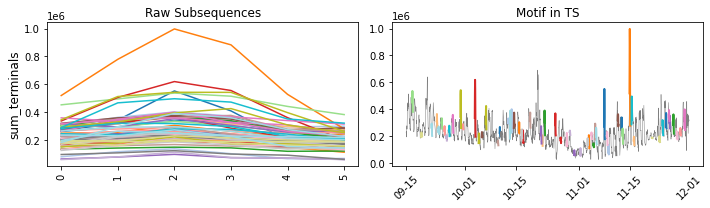

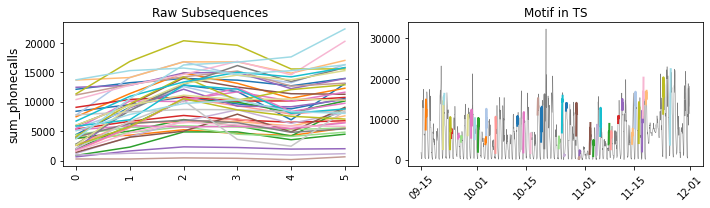

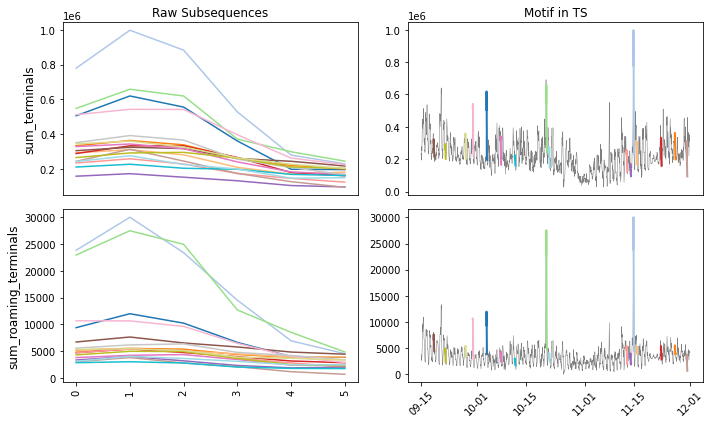

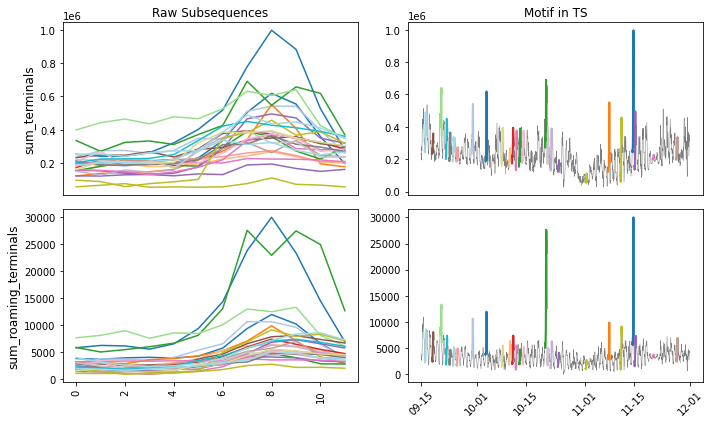

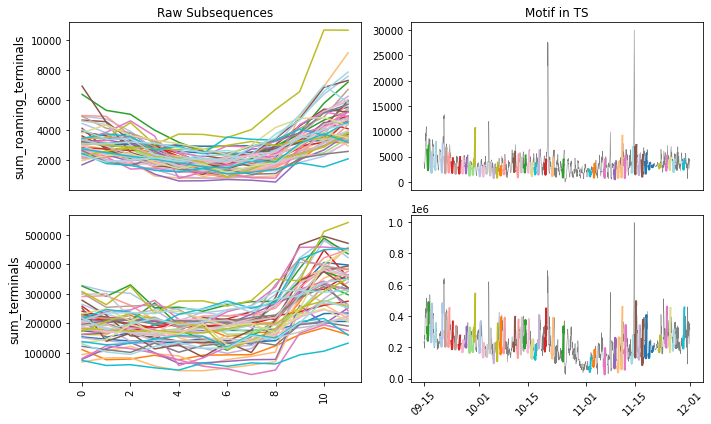

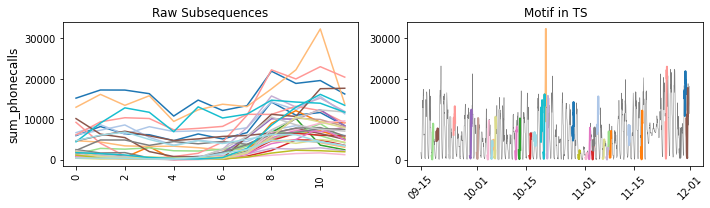

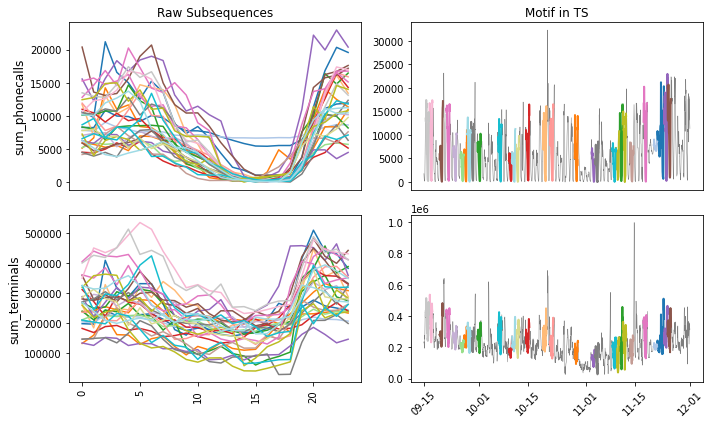

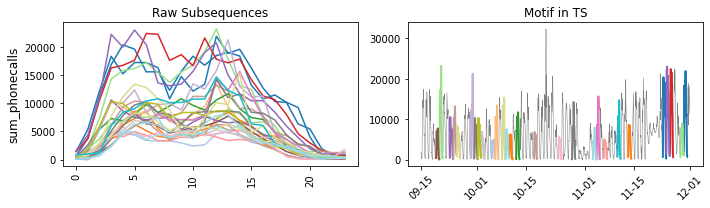

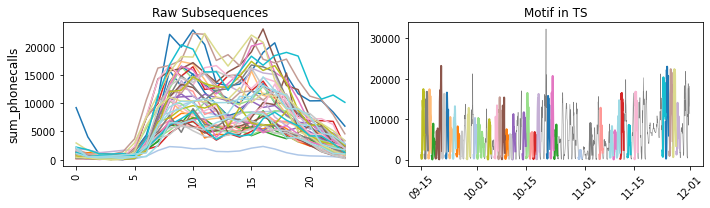

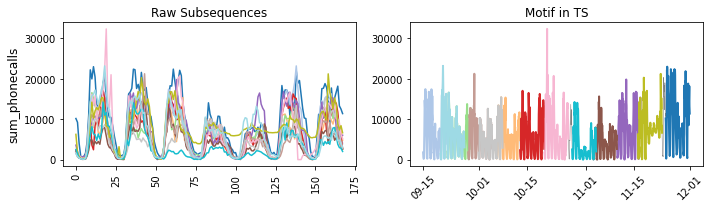

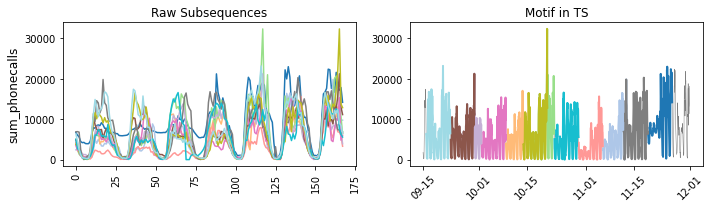

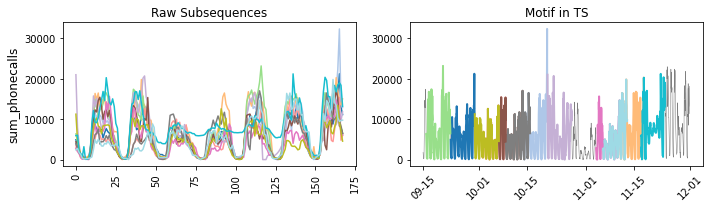

In [28]:
#plot top motif
for m in subsequence_lengths:
    print("Motif length: ", m)
    top_motifs = mp_stats_table[mp_stats_table["m"] == m].sort_values(by="p-value").head(3)
    for top_motif in top_motifs.to_dict(orient="records"): 
        m = top_motif["m"]
        dimensions = top_motif["Features"].split(",")
        dimensions = [int(dimension) for dimension in dimensions]
        features = [data.columns[dimension] for dimension in dimensions]
        indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
        indices = [int(i) for i in indices]
        motif_name = top_motif["ID"]
        ts_list = [data[feature] for feature in features]
        plot_motif(ts_list, features, m, indices, motif_name)